In this notebook, we plot the Figures relateed to vertical profiles of water vapour mixing ratio (MR).
Firstly, we focus on profiles as a function of gap length (to study large scale circulation);
Secondly, we study vertical profiles as a function of distance from clouds.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext memory_profiler
import matplotlib.gridspec as gridspec
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def setup_matplotlib(font_size=15):
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size, labelsize=font_size)
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.rc('legend', fontsize=font_size)
setup_matplotlib()
SIZE = 15

In [2]:
windspeed = xr.open_dataset('./../data/windspeed_eurec4a.nc')['wind_speed']
windspeed_avg = windspeed.sel(range = 1000, method = 'nearest').mean(dim = 'time')

#We load the cloud borders array that has been processed in the code "process_LW_BCO_data.ipynb"
clouds = np.loadtxt('./../data/processed_data/cloud_borders_2020.txt', delimiter=',', dtype='object') 
clouds[:, 0] = np.array(clouds[:, 0], dtype='datetime64[s]')
clouds[:, 1] = np.array(clouds[:, 1], dtype='datetime64[s]')
clouds[:, 2] = np.array(clouds[:, 2], dtype='float64')
clouds[:, 3] = np.array(clouds[:, 3], dtype='float64')
clouds[:, 4] = np.array(clouds[:, 4], dtype='float64')
clouds[:, 5] = np.array(clouds[:, 5], dtype='float64')

start_time = np.datetime64('2020-01-12T10:00:00')
end_time   = np.datetime64('2020-02-28T23:59:59')

#Since MR data is only available during Januray February (EUREC4A period), we restric our clouds during that time
clouds_time = clouds[(clouds[:, 0] >= start_time) & (clouds[:, 0] <= end_time)]


## Vertical profiles of water vapour mixing ratio as a function of gap length

In [27]:
#combined gaps is the averaged vertical profiles between clouds computed before
combined_gaps = xr.open_dataset('./../data/processed_data/vertical_profiles/combined_gaps.nc')['water vapour mixing ratio']*1000

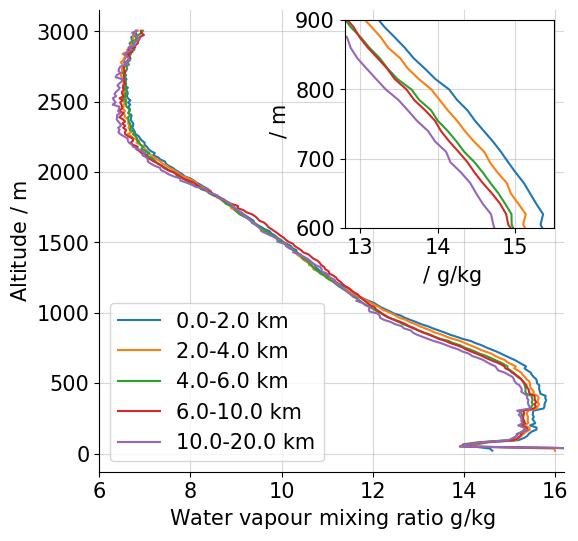

In [28]:
def plot_mean_vertical_profiles_gap(combined_gaps, distance_bins, windspeed_avg):
    """
    This function plots averaged vertical profiles for different gap lengths (as explained in the processing code "process_wvmr_profiles.ipynb"

    Inputs:
    - combined gaps: detailed before
    - distance bins: the different bins of gap length that we take into account 
    - windspeed_avg: average windspeed of the wind (used to convert time gaps into distance gaps)
    
    """
    # Plotting setup
    fig, ax = plt.subplots(figsize=(6, 6))

    #this loop separates the data into the bins
    for distance_bin in distance_bins:
        # Extract the lower and upper bounds of the distance bin
        lower_bound, upper_bound = distance_bin

        # Convert distance time indices of our gaps (lower and upper_bound) into lengths. Need to divide by windspeed and by 4 (as we have one data every 4 sec).
        lower_time_index = lower_bound / windspeed_avg.item() / 4
        upper_time_index = upper_bound / windspeed_avg.item() / 4

        # Filter gaps based on gap_length within the distance bin
        gaps_in_bin = combined_gaps.where((combined_gaps.gap_length >= lower_time_index) & 
                                           (combined_gaps.gap_length < upper_time_index), drop=True)

        # Compute the mean vertical profile for the filtered gaps
        gaps_mean = gaps_in_bin.mean(dim='gaps')

        # Plotting
        label = f'{lower_bound/1000}-{upper_bound/1000} km'
        ax.plot(gaps_mean, gaps_mean.alt, label=label)

    ax.set_xlabel(r'Water vapour mixing ratio ${\rm g/kg}$')
    ax.set_ylabel(r'Altitude / ${\rm m}$')
    ax.legend(loc='lower left')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.grid(alpha=0.5)
    ax.set_xlim(6, 16.2)

    #This creates a subplot into the main plot with a zoom in the bottom layer, where we have a lot of lcouds
    # Create inset of the zoomed-in region
    ax_inset = inset_axes(ax, width="45%", height="45%", loc='upper right')
    for distance_bin in distance_bins:
        # Extract the lower and upper bounds of the distance bin
        lower_bound, upper_bound = distance_bin

        # Convert distance bins to time indices
        lower_time_index = lower_bound / windspeed_avg.item() / 4
        upper_time_index = upper_bound / windspeed_avg.item() / 4

        # Filter gaps based on gap_length within the distance bin
        gaps_in_bin = combined_gaps.where((combined_gaps.gap_length >= lower_time_index) & 
                                           (combined_gaps.gap_length < upper_time_index), drop=True)

        # Compute the mean vertical profile for the filtered gaps
        gaps_mean = gaps_in_bin.mean(dim='gaps')

        # Plotting
        ax_inset.plot(gaps_mean, gaps_mean.alt)

    ax_inset.set_xlim(12.8, 15.5)
    ax_inset.set_ylim(600, 900)
    ax_inset.set_xlabel(r' / ${\rm g/kg}$', fontsize=15)
    ax_inset.set_ylabel(r' / ${\rm m}$', fontsize=SIZE)
    ax_inset.tick_params(axis='both', which='major', labelsize=SIZE)
    ax_inset.grid(alpha=0.5)

    plt.savefig('./../Figures/vertical_profile/vert_profile_gap_transition_with_zoomed_box.png', bbox_inches='tight')
    return fig, ax

# Define the distance bins in meters
distance_bins = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 10000), (10000, 20000)]

# Assuming combined_gaps is the result from the mr_profile_gaps function
fig, ax = plot_mean_vertical_profiles_gap(combined_gaps, distance_bins, windspeed_avg)

plt.show()


## Vertical profiles of water vapour mixing ratio as a function of distance from cloud

In [29]:
#masked_MR is the Mr that has been processed to put NaN each time there as a cloud, this is to avoid to take into account MR values in clouds
masked_MR = xr.open_dataset('./../data/processed_data/masked_MR.nc')['water vapour mixing ratio']

In [30]:
#We define differences between deep and shallow clouds:
clouds_deep = clouds_time[(clouds_time[:,2] >= 40) & (clouds_time[:,3] <= 1500) & (clouds_time[:,2] <= 10000) & ((clouds_time[:,4] - clouds_time[:,3]) >= 400) & ((clouds_time[:,4] - clouds_time[:,3]) <= 2500)]
clouds_shallow = clouds_time[(clouds_time[:,2] >= 40) & (clouds_time[:,3] <= 1500) & (clouds_time[:,2] <= 10000) & ((clouds_time[:,4] - clouds_time[:,3]) >= 100) & ((clouds_time[:,4] - clouds_time[:,3]) <= 600)]


In [31]:
def mr_profile_distances_distance(MR, clouds, distance_bins, windspeed_avg):
    """
    This function computes for each cloud averaged vertical profiles at different distances. It averages the vertical profiles of MR at different distance bins

    Inputs:
    - MR: the masked MR
    - clouds: arrays of clouds 
    - distance_bins: distance bins at which we average the profiles
    - windspeed_avg

    Outputs:
    - combined_profiles: averaged vertical profiles at the defined distance bins from clouds

    """
    
    profiles = []

    MR = MR.chunk({"time": 1000, "alt": 201}) # for faster processing
    delta_time = np.timedelta64(60, 'm')

    # Convert distance bins to time bins based on windspeed_avg
    time_bins = [(np.timedelta64(int(lower / windspeed_avg), 's'), np.timedelta64(int(upper / windspeed_avg), 's')) 
                 for lower, upper in distance_bins]

    #loop over each cloud
    for cloud_index, cloud_times in enumerate(clouds):
        start_time_cloud = np.datetime64(cloud_times[0])
        end_time_cloud = np.datetime64(cloud_times[1])
        
        end_time = end_time_cloud + delta_time
        
        # Select the MR values between the specified indices
        MR_after_cloud = MR.sel(time=slice(end_time_cloud, end_time)).compute()
        MR_after_cloud = MR_after_cloud.where((MR_after_cloud <= 0.03) & (MR_after_cloud >= 0.0001), drop=True)  # to keep only physical values


        #for each cloud, we bin the MR at the different distances
        bin_profiles = []
        for bin_index, (start_bin, end_bin) in enumerate(time_bins):
            bin_start_time = end_time_cloud + start_bin
            bin_end_time = end_time_cloud + end_bin
            MR_in_bin = MR_after_cloud.sel(time=slice(bin_start_time, bin_end_time)).mean(dim='time')
            MR_in_bin = MR_in_bin.assign_coords(profile=f'bin_{bin_index}')
            bin_profiles.append(MR_in_bin)
        
        # Concatenate profiles along a new dimension for this cloud
        cloud_profile = xr.concat(bin_profiles, dim='bin')
        profiles.append(cloud_profile)

    # Concatenate all cloud profiles along a new dimension
    combined_profiles = xr.concat(profiles, dim='cloud')

    return combined_profiles


In [32]:
distance_bins = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 10000), (10000, 20000)]
combined_profiles = mr_profile_distances_distance(masked_MR, clouds_shallow, distance_bins, windspeed_avg.item())

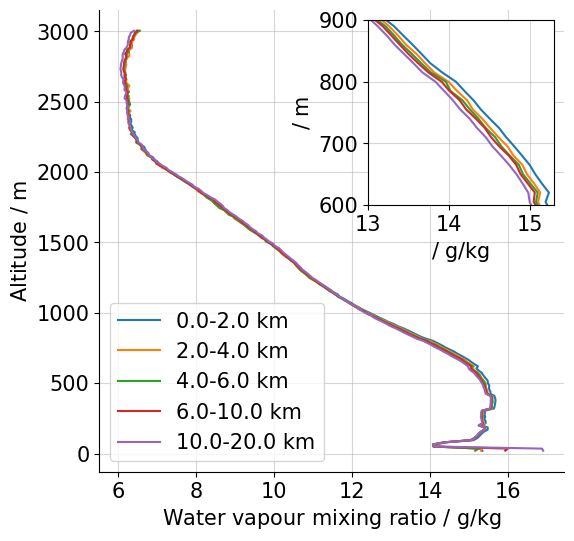

In [33]:
def plot_mean_vertical_profiles_distance(combined_profiles, distance_bins):
    """
    This function plots the combined_profiles defined previously in the same way as the plotting function plot_mean_vertical_profiles_gap()
    It plots it for different distance bins from clouds
    """
    
    plt.figure(figsize=(6, 6))

    # Compute the mean over clouds for each profile
    combined_profiles_mean = combined_profiles.mean(dim='cloud') * 1000

    for bin_index in range(len(distance_bins)):
        # Extract the mean profile for the current bin
        profile_mean = combined_profiles_mean.sel(bin=bin_index)

        # Create a label based on the distance bins
        lower_bound, upper_bound = distance_bins[bin_index]
        label = f'{lower_bound / 1000}-{upper_bound / 1000} km'

        # Plot the mean profile
        plt.plot(profile_mean, profile_mean.alt, label=label)

    plt.xlabel(r'Water vapour mixing ratio / ${\rm g/kg}$')
    plt.ylabel(r'Altitude / ${\rm m}$')
    plt.legend(loc = 'lower left')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(alpha=0.5)

    # Create inset of the zoomed-in region
    ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='upper right')
    for bin_index in range(len(distance_bins)):
        # Extract the mean profile for the current bin
        profile_mean = combined_profiles_mean.sel(bin=bin_index)
        
        # Plot the mean profile in the inset
        ax_inset.plot(profile_mean, profile_mean.alt)

    ax_inset.set_xlim(13, 15.3)
    ax_inset.set_ylim(600, 900)
    ax_inset.set_xlabel(r'/ ${\rm g/kg}$', fontsize=SIZE)
    ax_inset.set_ylabel(r'/ ${\rm m}$', fontsize=SIZE)
    ax_inset.tick_params(axis='both', which='major', labelsize=SIZE)
    ax_inset.grid(alpha=0.5)

    # Show the plot
    plt.savefig('./../Figures/vertical_profile/vert_profile_cloud_distance_with_zoomed_box.png', bbox_inches='tight')
    plt.show()

# Define the distance bins in meters
distance_bins = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 10000), (10000, 20000)]

# Assuming combined_profiles is the result from some previous function
plot_mean_vertical_profiles_distance(combined_profiles, distance_bins)


### Plots of up/down-wind differences

Using the profiles processed in the processing code, we can plot wvmr vertical profiles up- and downwind both for shallow and cumulus clouds

In [34]:
combined_profiles_before_shallow = xr.open_dataset('./../data/processed_data/vertical_profiles/combined_profiles_before_shallow.nc')['water vapour mixing ratio']*1000
combined_profiles_after_shallow = xr.open_dataset('./../data/processed_data/vertical_profiles/combined_profiles_after_shallow.nc')['water vapour mixing ratio']*1000
combined_profiles_before_deep = xr.open_dataset('./../data/processed_data/vertical_profiles/combined_profiles_before_deep.nc')['water vapour mixing ratio']*1000
combined_profiles_after_deep = xr.open_dataset('./../data/processed_data/vertical_profiles/combined_profiles_after_deep.nc')['water vapour mixing ratio']*1000

In [44]:
mean_before_shallow = combined_profiles_before_shallow.mean(dim='bin').mean(dim='cloud')
mean_after_shallow = combined_profiles_after_shallow.mean(dim='bin').mean(dim='cloud')
mean_before_deep = combined_profiles_before_deep.mean(dim='bin').mean(dim='cloud')
mean_after_deep = combined_profiles_after_deep.mean(dim='bin').mean(dim='cloud')

# Step 2: Stack the resulting DataArrays together
stacked_means = xr.concat(
    [mean_before_shallow, mean_after_shallow, mean_before_deep, mean_after_deep],
    dim='stacked_dim'
)

# Step 3: Compute the mean of the stacked DataArrays
overall_mean = stacked_means.mean(dim='stacked_dim')

In [162]:
distance_bins = [(500, 2000), (2000, 4000), (6000, 10000), (10000, 20000)]
"""
This function does 3 plots:
 1 - plot_before_after() does a full vertical profile up/downwind
 2 - plot_before_after_zoomed() same but zoomed on a specific zone (to observe better the heights differences
 3 - plot_diff() plots the difference between up and downwind to observe a change

"""
def plot_vertical_profiles_up_down(combined_profiles_before, combined_profiles_after, distance_bins, type_cloud, additional_title_text=""):
    combined_profiles_before_mean = combined_profiles_before.mean(dim='cloud')
    combined_profiles_after_mean = combined_profiles_after.mean(dim='cloud')

    colors = plt.cm.viridis(np.linspace(0, 1, len(distance_bins)))

    # Plot 1: Vertical profile before and after clouds
    def plot_before_after():
        plt.figure(figsize=(8, 6))
        for bin_index in range(len(distance_bins)):
            profile_before_mean = combined_profiles_before_mean.sel(bin=bin_index) - overall_mean
            profile_after_mean = combined_profiles_after_mean.sel(bin=bin_index) - overall_mean
            
            lower_bound, upper_bound = distance_bins[bin_index]
            label_before = f'Downwind {lower_bound / 1000}-{upper_bound / 1000} km'
            label_after = f'Upwind {lower_bound / 1000}-{upper_bound / 1000} km'
            
            plt.plot(profile_before_mean, profile_before_mean.alt, linestyle='--', label=label_before, color=colors[bin_index])
            plt.plot(profile_after_mean, profile_after_mean.alt, linestyle='-', label=label_after, color=colors[bin_index])

        plt.xlabel(r'wvmr anomalies / ${\rm g/kg}$')
        plt.ylabel(r'Altitude / ${\rm m}$')
        #plt.title(f'Vertical profile of water vapor mixing ratio for different distance bins before and after clouds: {additional_title_text}')
        plt.legend(loc='upper center', bbox_to_anchor=(1.25, 0.9), ncol=1, frameon=False)
        plt.grid(alpha=0.5)
        plt.ylim(100, 1800)
        plt.xlim(-0.25, 0.25)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.savefig(f'./../Figures/vertical_profile/vert_profile_cloud_distance_up_down_{type_cloud}.png', bbox_inches='tight')
        plt.show()

    # Plot 2: Vertical profile before and after clouds (zoomed in)
    def plot_before_after_zoomed():
        plt.figure(figsize=(10, 6))
        for bin_index in range(len(distance_bins)):
            profile_before_mean = combined_profiles_before_mean.sel(bin=bin_index)- overall_mean
            profile_after_mean = combined_profiles_after_mean.sel(bin=bin_index)- overall_mean
            
            lower_bound, upper_bound = distance_bins[bin_index]
            label_before = f'Downwind {lower_bound / 1000}-{upper_bound / 1000} km'
            label_after = f'Upwind {lower_bound / 1000}-{upper_bound / 1000} km'
            
            plt.plot(profile_before_mean, profile_before_mean.alt, linestyle='--', label=label_before, color=colors[bin_index])
            plt.plot(profile_after_mean, profile_after_mean.alt, linestyle='-', label=label_after, color=colors[bin_index])

        plt.xlabel(r'wvmr / ${\rm g/kg}$')
        plt.ylabel(r'Altitude / ${\rm m}$')
        #plt.title(f'Vertical profile of water vapor mixing ratio for different distance bins before and after clouds: {additional_title_text}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.ylim(600, 1000)
        #plt.xlim(12.3, 15.3)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.savefig(f'./../Figures/vertical_profile/vert_profile_cloud_distance_up_down_zoomed_{type_cloud}.png', bbox_inches='tight')
        plt.show()

    # Generate all three plots
    plot_before_after()
    #plot_before_after_zoomed()

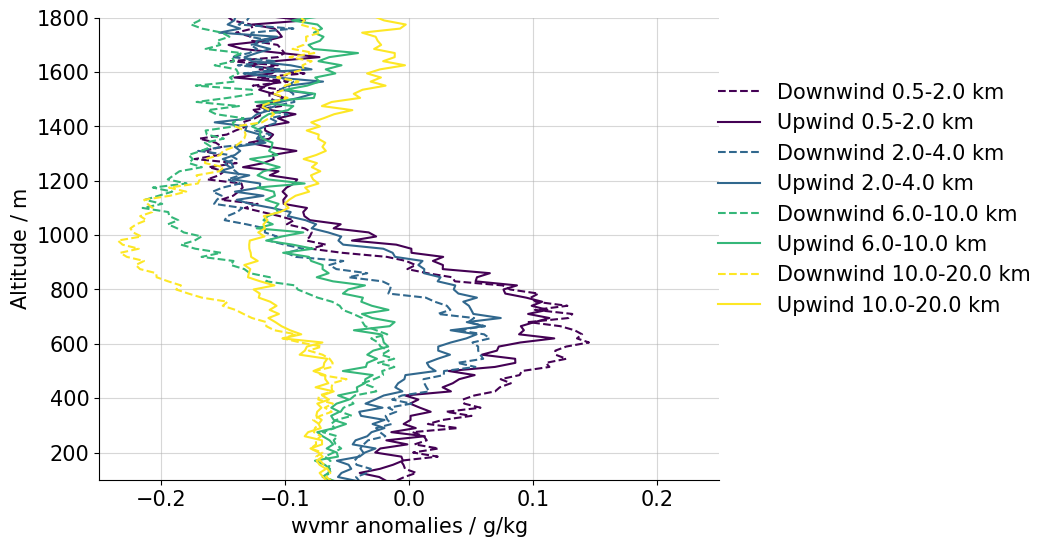

In [163]:
plot_vertical_profiles_up_down(combined_profiles_before_shallow, combined_profiles_after_shallow, distance_bins, 'shallow', 'Shallow clouds')

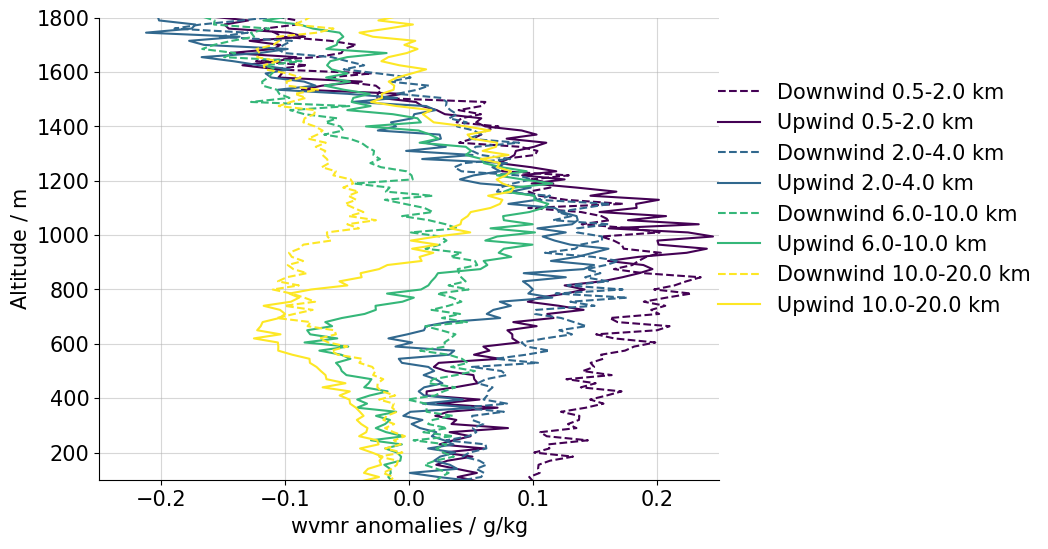

In [164]:
plot_vertical_profiles_up_down(combined_profiles_before_deep, combined_profiles_after_deep, distance_bins, 'deep', 'Deep clouds')

### averaging over 3 heights: subcloud, cloud and above cloud. And comparing shallow and cumulus clouds

We now want to compare shallow and cumulus clouds profiles, both up- and downwind from clouds at three distinct height levels

In [77]:
"""
The idea of this function is to separate the vertical profiles into 3 averaged profiles: first 200m below the cloud, then the cloud, and 200m above it. 
This is with the approximation that we take the means base and top of the clouds and not individually
"""
def separate_altitude_ranges_single(combined_profiles_diff_up_down, mean_base, mean_top):
    # Define the altitude ranges
    lower_range = (mean_base - 200, mean_base)
    middle_range = (mean_base, mean_top)
    upper_range = (mean_top, mean_top + 200)
    
    # Create masks for the altitude ranges
    lower_mask = (combined_profiles_diff_up_down.alt >= lower_range[0]) & (combined_profiles_diff_up_down.alt <= lower_range[1])
    middle_mask = (combined_profiles_diff_up_down.alt >= middle_range[0]) & (combined_profiles_diff_up_down.alt <= middle_range[1])
    upper_mask = (combined_profiles_diff_up_down.alt >= upper_range[0]) & (combined_profiles_diff_up_down.alt <= upper_range[1])

    # Select and average profiles based on masks
    lower_avg = combined_profiles_diff_up_down.where(lower_mask, drop=True).mean(dim='alt')
    middle_avg = combined_profiles_diff_up_down.where(middle_mask, drop=True).mean(dim='alt')
    upper_avg = combined_profiles_diff_up_down.where(upper_mask, drop=True).mean(dim='alt')

    # Concatenate the averages into a single xarray DataArray with new alt coordinates
    result = xr.concat([lower_avg, middle_avg, upper_avg], dim='alt').assign_coords(alt=[(mean_base - 100), (mean_base + mean_top) / 2, (mean_top + 100)])

    return result

In [78]:
"""
This function plots the averaged profiles at the three points defined by the function separate_altitude_ranges_single()
"""
def plot_vertical_difference_3_heights_up_down(combined_profiles_before_shallow, combined_profiles_after_shallow,
                                               combined_profiles_before_deep, combined_profiles_after_deep,
                                               distance_bins):
    # Compute mean bases and tops for shallow and deep clouds
    mean_base_shallow = clouds_shallow[:, 3].mean()
    mean_top_shallow = clouds_shallow[:, 4].mean()
    mean_base_deep = clouds_deep[:, 3].mean()
    mean_top_deep = clouds_deep[:, 4].mean()

    colors = plt.cm.viridis(np.linspace(0, 1, len(distance_bins)))
    y_labels = ['SCL', 'CL ', 'TCL']
    
    def compute_and_plot_diff(ax, combined_profiles_before, combined_profiles_after, mean_base, mean_top, title_suffix, show_legend):
        #compute the difference up/downwind and bin it with altitude
        combined_profiles_diff_up_down = combined_profiles_before - combined_profiles_after
        binned_profile_diff = separate_altitude_ranges_single(combined_profiles_diff_up_down, mean_base, mean_top)
        binned_profile_diff_mean = binned_profile_diff.mean(dim='cloud')

        #here for each bin(i.e., each distance from the cloud), we plot the profile
        for bin_index in range(len(distance_bins)):
            profile_diff_mean = binned_profile_diff_mean.sel(bin=bin_index)
            lower_bound, upper_bound = distance_bins[bin_index]
            label_diff = f'{lower_bound / 1000}-{upper_bound / 1000} km'
            ax.plot(profile_diff_mean, profile_diff_mean.alt, label=label_diff, color=colors[bin_index], marker='.')

        # Set custom y-axis ticks and labels to match with the idea of the function
        y_ticks = [mean_base - 100, (mean_base + mean_top) / 2, mean_top + 100]
        
        ax.set_yticks(y_ticks)
        #ax.set_yticklabels(y_labels)

        ax.set_xlabel(r'wvmr / ${\rm g/kg}$')
        #ax.set_ylabel('Altitude / m')
        ax.set_title(f'{title_suffix}')
        if show_legend:
            ax.legend(loc = 'lower left')

        ax.grid(alpha=0.5)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    compute_and_plot_diff(axs[0], combined_profiles_before_shallow, combined_profiles_after_shallow,
                          mean_base_shallow, mean_top_shallow, "Shallow clouds", show_legend=True)

    compute_and_plot_diff(axs[1], combined_profiles_before_deep, combined_profiles_after_deep,
                          mean_base_deep, mean_top_deep, "Deep clouds", show_legend=False)

    axs[0].set_yticklabels(y_labels)
    axs[1].set_yticklabels(['','',''])
    plt.tight_layout()
    plt.savefig(f'./../Figures/vertical_profile/vert_profile_3_heights_up_down.png', bbox_inches='tight')
    plt.show()


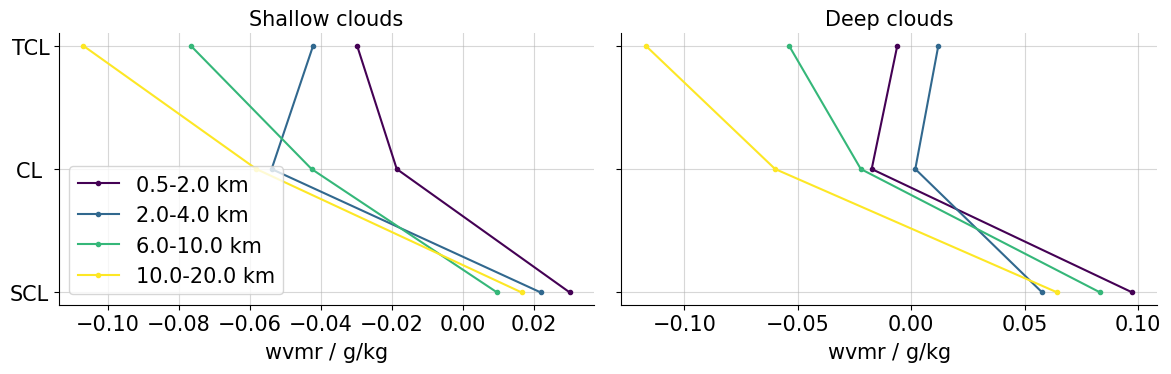

In [79]:
plot_vertical_difference_3_heights_up_down(combined_profiles_before_shallow, combined_profiles_after_shallow,
                                                   combined_profiles_before_deep, combined_profiles_after_deep,
                                                   distance_bins)